In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt



2024-12-04 08:48:26.080916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733302106.326749    1728 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733302106.390484    1728 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 08:48:27.024565: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base = '/home/rob/'
csv_file = os.path.join(base, 'ham10000_data/HAM10000_metadata.csv')
img_dir = os.path.join(base, 'ham10000_data/images')
file_ext = '.jpg'

df = pd.read_csv(csv_file)
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(img_dir, x + file_ext))
class_names = df['dx'].unique()

print(df.head())


     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                        image_path  
0  /home/rob/ham10000_data/images/ISIC_0027419.jpg  
1  /home/rob/ham10000_data/images/ISIC_0025030.jpg  
2  /home/rob/ham10000_data/images/ISIC_0026769.jpg  
3  /home/rob/ham10000_data/images/ISIC_0025661.jpg  
4  /home/rob/ham10000_data/images/ISIC_0031633.jpg  


In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['dx'], random_state=42)

train_sizes = train_df['dx'].value_counts()
print("Train sizes per label:")
print(train_sizes)

# Print the sizes of each label in the test set
test_sizes = test_df['dx'].value_counts()
print("\nTest sizes per label:")
print(test_sizes)

# Optionally, check the total sizes
print(f"\nTotal train size: {len(train_df)}")
print(f"Total test size: {len(test_df)}")

Train sizes per label:
dx
nv       5364
mel       890
bkl       879
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64

Test sizes per label:
dx
nv       1341
mel       223
bkl       220
bcc       103
akiec      65
vasc       28
df         23
Name: count, dtype: int64

Total train size: 8012
Total test size: 2003


In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

datagen_train = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_test = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42,
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, len(class_names)])
).repeat()
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, len(class_names)])
).repeat()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)



Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


I0000 00:00:1733302114.808056    1728 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:0b:00.0, compute capability: 6.0
I0000 00:00:1733302114.808649    1728 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 15513 MB memory:  -> device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:13:00.0, compute capability: 6.0


In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base model

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)  # Regularization
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [6]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_path = 'models/best_model_resnet50.keras'

callbacks = [
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_accuracy', verbose=1)
]

In [8]:
class_weights_array = compute_class_weight('balanced', classes=np.unique(df['dx']), y=df['dx'])
class_weights_dict = {train_generator.class_indices[class_name]: weight
                      for class_name, weight in zip(np.unique(df['dx']), class_weights_array)}

print(class_weights_dict)
print(train_generator.class_indices)
dx_counts = train_df['dx'].value_counts()
print(dx_counts)

{0: np.float64(4.375273044997815), 1: np.float64(2.78349082823791), 2: np.float64(1.301832835044846), 3: np.float64(12.440993788819876), 4: np.float64(1.2854575792581184), 5: np.float64(0.21338020666879728), 6: np.float64(10.075452716297788)}
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
dx
nv       5364
mel       890
bkl       879
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64


In [9]:
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(test_df) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

Epoch 1/20


I0000 00:00:1733302124.781912    1829 service.cc:148] XLA service 0x74fc0404c1f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733302124.782502    1829 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733302124.782521    1829 service.cc:156]   StreamExecutor device (1): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-12-04 08:48:45.015327: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733302126.186306    1829 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-04 08:48:47.425159: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim

  2/250 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.1016 - loss: 2.8238 

I0000 00:00:1733302130.035148    1829 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.5844 - loss: 1.4290
Epoch 1: val_accuracy improved from -inf to 0.66986, saving model to models/best_model_resnet50.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 173s 647ms/step - accuracy: 0.5846 - loss: 1.4283 - val_accuracy: 0.6699 - val_loss: 1.1322 - learning_rate: 0.0010
Epoch 2/20


2024-12-04 08:51:32.683806: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[12,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-04 08:51:32.841078: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[12,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForw

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.6656 - loss: 1.1687

2024-12-04 08:53:45.809500: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[19,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-04 08:53:46.010368: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[19,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForw


Epoch 2: val_accuracy did not improve from 0.66986
250/250 ━━━━━━━━━━━━━━━━━━━━ 148s 579ms/step - accuracy: 0.6657 - loss: 1.1687 - val_accuracy: 0.6687 - val_loss: 1.1282 - learning_rate: 0.0010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.6800 - loss: 1.1343
Epoch 3: val_accuracy did not improve from 0.66986
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 569ms/step - accuracy: 0.6799 - loss: 1.1344 - val_accuracy: 0.6677 - val_loss: 1.1280 - learning_rate: 0.0010
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.6686 - loss: 1.1487
Epoch 4: val_accuracy improved from 0.66986 to 0.67073, saving model to models/best_model_resnet50.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 558ms/step - accuracy: 0.6686 - loss: 1.1487 - val_accuracy: 0.6707 - val_loss: 1.1253 - learning_rate: 0.0010
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.6646 - loss: 1.1472
Epoch 5: val_accuracy improved from 0.67073 to 0.67123, saving model to models/best_model_res

In [10]:
base_model.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [11]:


steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(test_df) // BATCH_SIZE

fine_tune_history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.4992 - loss: 2.2946
Epoch 1: val_accuracy did not improve from 0.67123
250/250 ━━━━━━━━━━━━━━━━━━━━ 216s 665ms/step - accuracy: 0.4995 - loss: 2.2930 - val_accuracy: 0.6662 - val_loss: 7.6531 - learning_rate: 1.0000e-05
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.6667 - loss: 1.2887
Epoch 2: val_accuracy did not improve from 0.67123
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 571ms/step - accuracy: 0.6667 - loss: 1.2884 - val_accuracy: 0.6372 - val_loss: 7.2959 - learning_rate: 1.0000e-05
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.6917 - loss: 0.9763
Epoch 3: val_accuracy did not improve from 0.67123
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 563ms/step - accuracy: 0.6918 - loss: 0.9762 - val_accuracy: 0.6687 - val_loss: 3.9439 - learning_rate: 1.0000e-05
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.7234 - loss: 0.8423
Epoch 4: val_accuracy improved from 0.67123 to 0

In [ ]:
model.load_weights(model_path)


In [13]:
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


/home/rob/.notebook/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.8023 - loss: 0.5404
Test Loss: 0.5056309103965759
Test Accuracy: 0.8217673301696777


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 238ms/step
Classification Report:
               precision    recall  f1-score   support

         bkl       0.82      0.42      0.55        65
          nv       0.65      0.68      0.67       103
          df       0.53      0.84      0.65       220
         mel       0.57      0.17      0.27        23
        vasc       0.62      0.61      0.61       223
         bcc       0.95      0.90      0.92      1341
       akiec       0.89      0.61      0.72        28

    accuracy                           0.82      2003
   macro avg       0.72      0.60      0.63      2003
weighted avg       0.84      0.82      0.82      2003



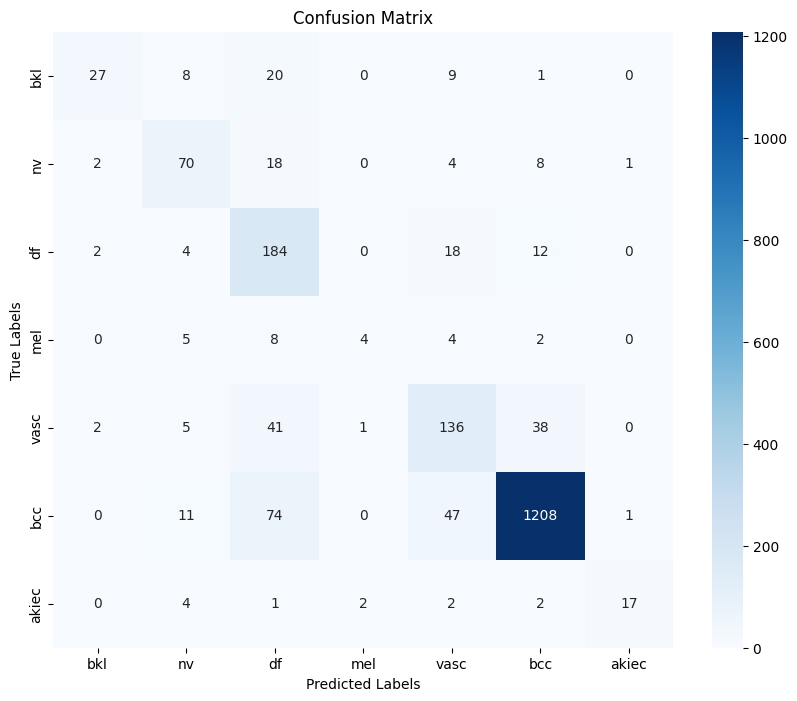

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
